# TP - Statistique


Dans un premier temps, nous allons ajoutez nos bibliothèques ainsi que importer notre bases de données.
Notre base de donnée 'UserdCarData' proviens de https://www.kaggle.com/datasets/shubham1kumar/usedcar-data?select=UserCarData.csv

In [2]:
"""
27/05/2024
BELLONCLE Robin - BOTHUA Pierre

                                        Projet Base de Données
                                        Mathématiques statistique
                                        
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Charger le fichier CSV
file_path = 'UserCarData.csv'
Data = pd.read_csv(file_path, sep=',')
Data.columns = [col.strip() for col in Data.columns]  # Supprimer les espaces autour des noms de colonnes



Ensuite nous allons afficher la répartitions des données entre le prix de ventes et le kilométage des véhicules 

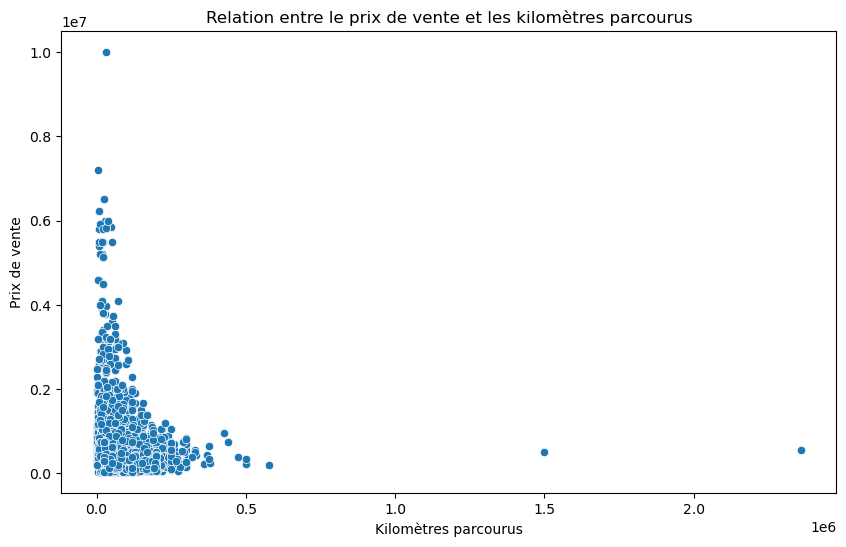

In [3]:
# Sélection des colonnes pour l'analyse
columns = ["year", "selling_price", "km_driven", "mileage", "engine", "max_power", "seats"]
year_data, selling_price_data, km_driven_data, mileage_data, engine_data, max_power_data, seats_data = [Data[col] for col in columns]

# Relation entre le prix de vente et les kilomètres parcourus
plt.figure(figsize=(10, 6))
sns.scatterplot(x=km_driven_data, y=selling_price_data)
plt.xlabel('Kilomètres parcourus')
plt.ylabel('Prix de vente')
plt.title('Relation entre le prix de vente et les kilomètres parcourus')
plt.show()



Nous réalison la matrice de corélation afin de visuelaliser quel valeur sont le plus en liens avec les quels afin de determiner les facteurs

               selling_price  km_driven      year   mileage  max_power
selling_price       1.000000  -0.222158  0.412302 -0.126280   0.749674
km_driven          -0.222158   1.000000 -0.428548 -0.172980  -0.038159
year                0.412302  -0.428548  1.000000  0.328544   0.226598
mileage            -0.126280  -0.172980  0.328544  1.000000  -0.374621
max_power           0.749674  -0.038159  0.226598 -0.374621   1.000000


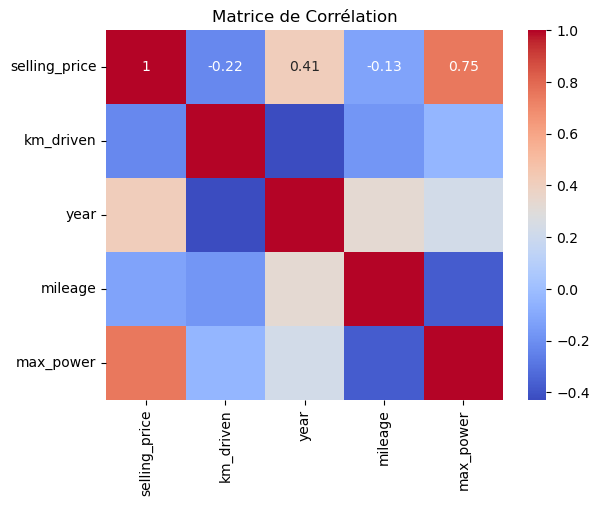

In [4]:
# Matrice de corrélation
correlation_matrix = Data[['selling_price', 'km_driven', 'year', 'mileage', 'max_power']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

Pour repondre à question de recherche qui est :
Comment estimer une valeurs dans les prix du amrché pour un vehicul en fonction de sa puissance, sont année de fabrication ainsi que sont kilométrage.

Pour réaliser cela nous réalison une régression lineaire multiple

In [5]:
# Regression linéaire multiple
# Ajout d’une constante pour l’intercept
X = sm.add_constant(Data[['year', 'km_driven', 'max_power']])
# Ajustement du modèle
model = sm.OLS(Data['selling_price'], X).fit()
# Affichage du résumé du modèle
print(model.summary())

# Sélection Pas-à-Pas avec colonnes limitées
def forward_selection_limited(data, response):
    predictors = ['year', 'km_driven', 'max_power']
    remaining = set(predictors)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            score = sm.OLS.from_formula(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.OLS.from_formula(formula, data).fit()
    return model

# Application de la sélection pas-à-pas aux données
limited_model = forward_selection_limited(Data, 'selling_price')
print(limited_model.summary())



                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4545.
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:52:29   Log-Likelihood:            -1.1485e+05
No. Observations:                7906   AIC:                         2.297e+05
Df Residuals:                    7902   BIC:                         2.297e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.915e+07   3.29e+06    -27.111      0.0

Estimation du prix de ventes pour un vehicule grace au coeficient trouvée précédement 

In [6]:
# Prediction function using the model
def predict_selling_price(model, year, km_driven, max_power):
    # Extract coefficients from the model
    intercept = model.params['Intercept']
    beta_year = model.params['year']
    beta_km_driven = model.params['km_driven']
    beta_max_power = model.params['max_power']

    # Calculate the predicted selling price
    predicted_price = (
        intercept +
        (beta_year * year) +
        (beta_km_driven * km_driven) +
        (beta_max_power * max_power)
    )
    return predicted_price

# Given values for a car: year=2018, km_driven=60000, max_power=165
year = 2018
km_driven = 60000
max_power = 165

# Predict the selling price
predicted_price = predict_selling_price(limited_model, year, km_driven, max_power)
print(f"Predicted selling price for a car from {year} with {max_power} hp and {km_driven} km driven: {predicted_price:.2f}")

Predicted selling price for a car from 2018 with 165 hp and 60000 km driven: 2007006.10


Maitnenat nous souhaiton voir si chaque marque parmis les 6 les plus présente à des choix de gammes distinc, càd une marque produisant des voiture peu puissante ou bien des voiture peu chère par exemple

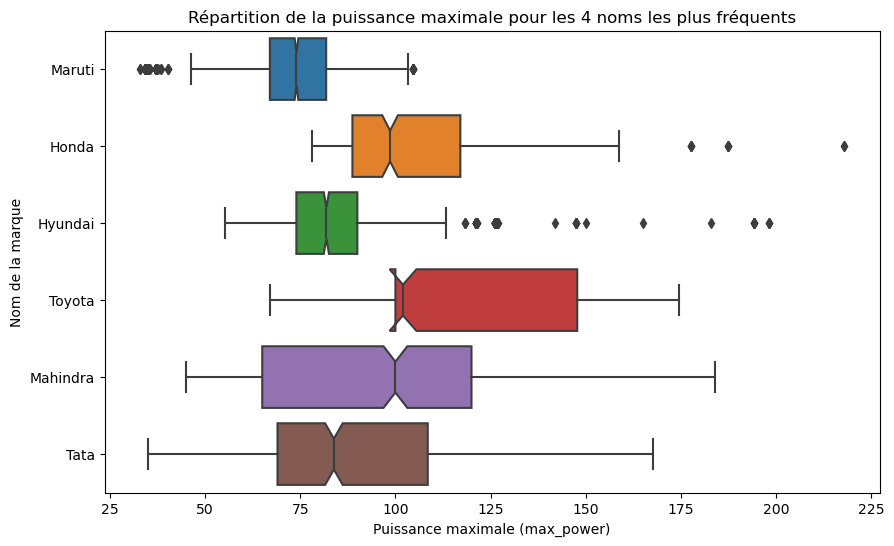

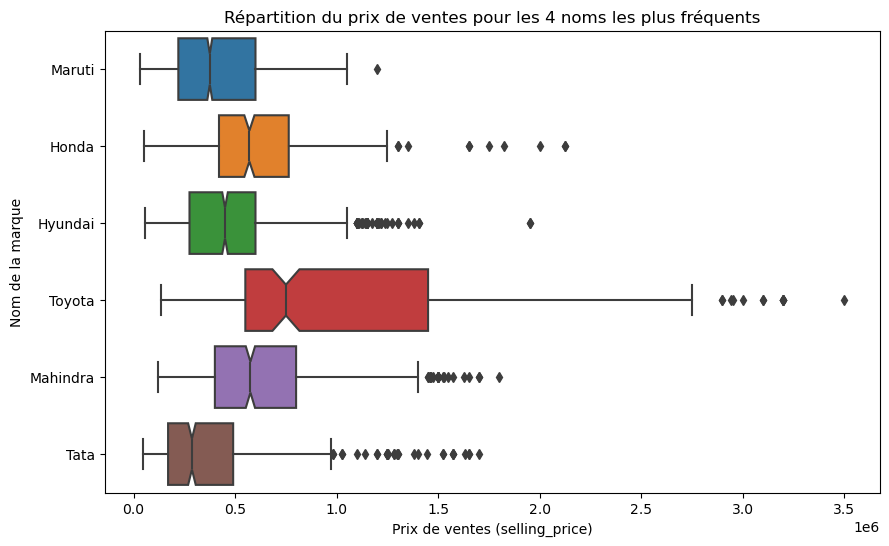

In [7]:
# Boxplot de la puissance maximale pour les 6 noms les plus fréquents
top_4_names = Data['name'].value_counts().nlargest(6).index
filtered_data = Data[Data['name'].isin(top_4_names)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='max_power', y='name', notch=True)
plt.title("Répartition de la puissance maximale pour les 4 noms les plus fréquents")
plt.xlabel("Puissance maximale (max_power)")
plt.ylabel("Nom de la marque")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='selling_price', y='name', notch=True)
plt.title("Répartition du prix de ventes pour les 4 noms les plus fréquents")
plt.xlabel("Prix de ventes (selling_price)")
plt.ylabel("Nom de la marque")
plt.show()